In [1]:
import torch
import time
import ot

import numpy as np
import matplotlib.pyplot as plt

from geoopt import Lorentz as Lorentz_geoopt

from utils.hmds import HyperMDS
from utils.datasets import *
from utils.bures_wasserstein import LabelsBW

from hswfs.manifold.euclidean import Euclidean
from hswfs.manifold.product import ProductManifold
from hswfs.manifold.poincare import Poincare
from hswfs.manifold.lorentz import Lorentz
from hswfs.sw import sliced_wasserstein

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Datasets

In [3]:
names = ['MNIST','EMNIST','FashionMNIST','KMNIST','USPS']
train_all = [loaders_NIST(name).get_dataset()[0] for name in names]
test_all = [loaders_NIST(name).get_dataset()[1] for name in names]
train_dict = dict(list(zip(names,train_all)))
test_dict = dict(list(zip(names,test_all)))

### HyperMDS

In [4]:
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

emb = LabelsBW(device=device, maxsamples=10000) ## 60000) #?
distance_array = emb.dissimilarity_for_all(train_all)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [5]:
tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

lorentz_geoopt = Lorentz_geoopt()

scaling = 0.1
d = 10

embedding = HyperMDS(d, lorentz_geoopt, torch.optim.Adam, scaling=scaling, loss="ads")
mds, L = embedding.fit_transform(torch.tensor(distance_array, dtype=torch.float64), n_epochs=50000, lr=1e-3)

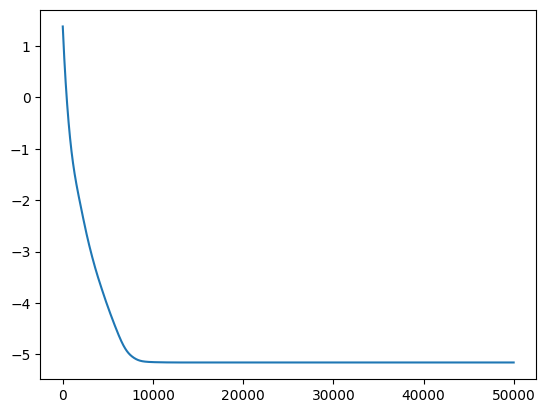

In [6]:
plt.plot(np.log(np.array(L)))
plt.show()

In [7]:
dist_mds = lorentz_geoopt.dist(mds[None], mds[:,None]).detach().cpu().numpy()

diff_dist = np.abs(scaling * distance_array - dist_mds)

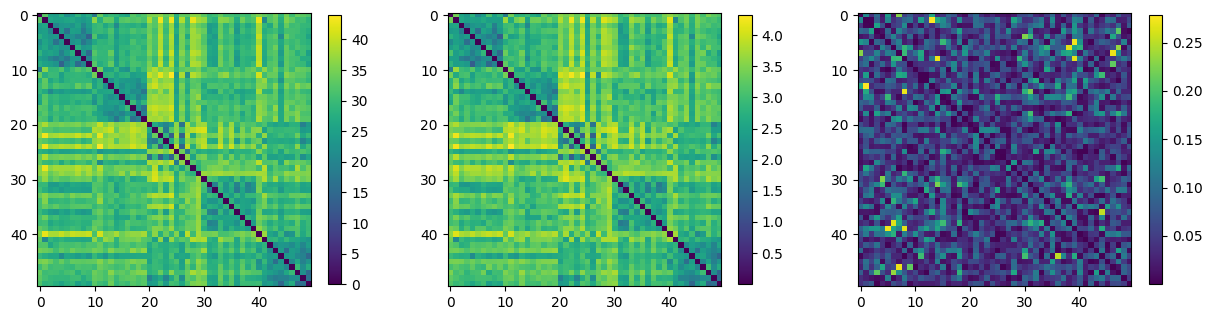

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15,7))
cb = ax[0].imshow(distance_array)
fig.colorbar(cb, ax=ax[0], shrink=0.5)

cb = ax[1].imshow(dist_mds)
fig.colorbar(cb, ax=ax[1], shrink=0.5)

cb = ax[2].imshow(diff_dist)
fig.colorbar(cb, ax=ax[2], shrink=0.5)

plt.show()

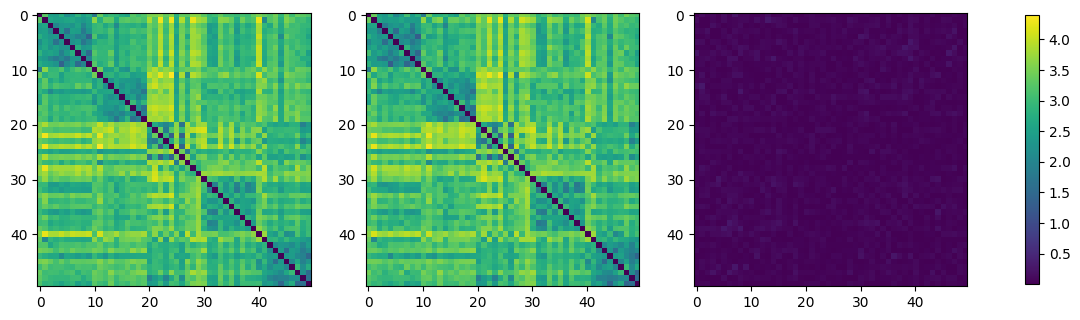

In [9]:
maxi = max(np.max(scaling * distance_array), np.max(dist_mds))

fig, ax = plt.subplots(1, 3, figsize=(15,7))
ax[0].imshow(scaling * distance_array, vmax=maxi)
ax[1].imshow(dist_mds, vmax=maxi)

cb = ax[2].imshow(diff_dist, vmax=maxi)
fig.colorbar(cb, ax=ax, location="right", shrink=0.5)

plt.show()

In [10]:
-mds[:,0]**2 + torch.sum(mds[:,1:]**2, axis=-1)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000], dtype=torch.float64, grad_fn=<AddBackward0>)

### OTDD

In [11]:
data_X = [] # data
data_Y = [] # labels

for idx, dataset in enumerate(train_all):
    X, Y = emb.preprocess_dataset(dataset)
    label_emb = mds[emb.class_num*idx:emb.class_num*(idx+1)].detach().numpy()
    labels = torch.stack([torch.from_numpy(label_emb[target])
                         for target in Y], dim=0).squeeze(1).to(device)

    data_X.append(X)
    data_Y.append(labels)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

In [12]:
d_y = data_Y[0].shape[1]

manifolds = [Euclidean(28*28, device=device), Lorentz(d_y, projection="horospheric", device=device)]
product_manifold = ProductManifold(manifolds, torch.ones((2,), device=device)/np.sqrt(2))

n_projs = 500

d_sw = np.zeros((5,5))

for i in range(5):
    for j in range(i):    
        sw = sliced_wasserstein([data_X[i], data_Y[i]], [data_X[j], data_Y[j]], n_projs, product_manifold)
        d_sw[i, j] = sw.item()
        d_sw[j, i] = sw.item()

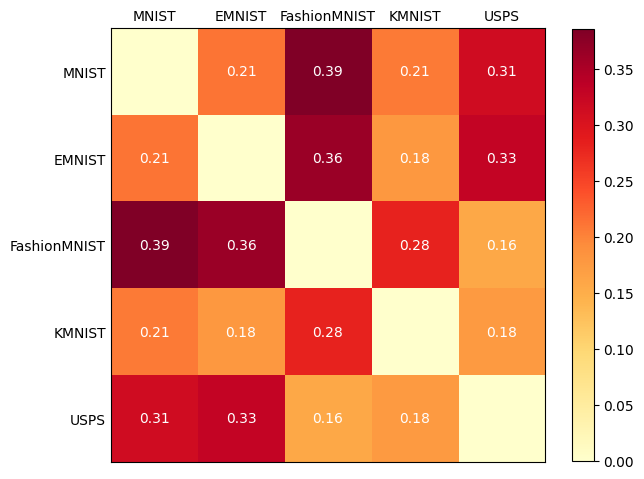

In [17]:
## SW + labels

fig, ax = plt.subplots(1,1,figsize=(7,7))
# ax.imshow(d_sw)
cb = ax.imshow(d_sw, cmap="YlOrRd")

for (j,i),label in np.ndenumerate(d_sw):
    if i!=j:
        ax.text(i, j, np.round(label, 2) ,ha='center', va='center', c="white")
    
ax.xaxis.tick_top()

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(names)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(names)

ax.tick_params(axis=u'both', which=u'both',length=0)
    
fig.colorbar(cb, ax=ax, shrink=0.8)
plt.show()

In [18]:
ts = []

d_sw = np.zeros((100,5,5))


for k in range(100):
    
    d_y = data_Y[0].shape[1]

    manifolds = [Euclidean(28*28, device=device), Lorentz(d_y, projection="horospheric", device=device)]
    product_manifold = ProductManifold(manifolds, torch.ones((2,), device=device)/np.sqrt(2))

    n_projs = 500
    
    t = 0

    for i in range(5):
        for j in range(i):
            t_init = time.time()
            sw = sliced_wasserstein([data_X[i], data_Y[i]], [data_X[j], data_Y[j]], n_projs, product_manifold)
            t += time.time()-t_init
            d_sw[k, i, j] = sw.item()
            d_sw[k, j, i] = sw.item()
    
    ts.append(t)

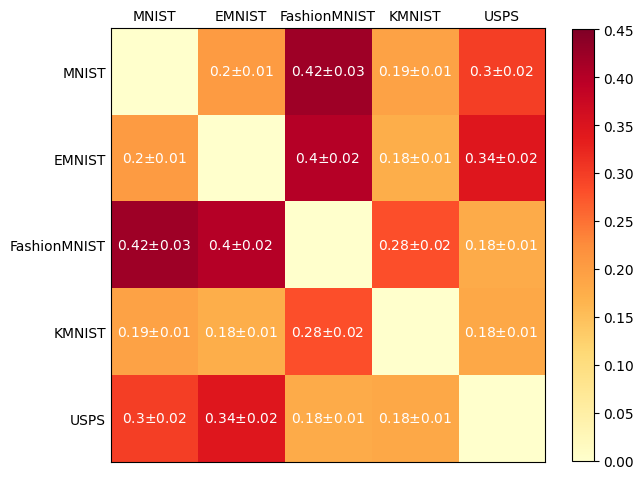

In [19]:
d_mean_sw = np.mean(d_sw, axis=0)
d_std_sw = np.std(d_sw, axis=0)

## SW + labels

fig, ax = plt.subplots(1,1,figsize=(7,7))
cb = ax.imshow(d_mean_sw, cmap="YlOrRd", vmax=0.45)

for (j,i),label in np.ndenumerate(d_mean_sw):
    if i!= j:
        ax.text(i, j, str(np.round(label, 2)) + r"$\pm$" + str(np.round(d_std_sw[i, j], 2)),
                ha='center', va='center', c="white")

ax.xaxis.tick_top()

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(names)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(names)

ax.tick_params(axis=u'both', which=u'both',length=0)

fig.colorbar(cb, ax=ax, shrink=0.8)

plt.savefig("./dist_matrix_product_sw.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [20]:
print(np.mean(ts), np.std(ts))

0.06262369155883789 0.0010455099251885291


### Baseline: only SW on data

In [21]:
ts = []

d_sw = np.zeros((100,5,5))


for k in range(100):
    
    d_y = data_Y[0].shape[1]

#     manifolds = [Euclidean(28*28, device=device), Lorentz(d_y, projection="horospheric", device=device)]
#     product_manifold = ProductManifold(manifolds, torch.ones((2,), device=device)/np.sqrt(2))
    manifold = Euclidean(28*28, device=device)

    n_projs = 500
    
    t = 0

    for i in range(5):
        for j in range(i):
            t_init = time.time()
            sw = sliced_wasserstein(data_X[i], data_X[j], n_projs, manifold)
#             sw = sliced_wasserstein([data_X[i], data_Y[i]], [data_X[j], data_Y[j]], n_projs, product_manifold)
            t += time.time()-t_init
            d_sw[k, i, j] = sw.item()
            d_sw[k, j, i] = sw.item()
    
    ts.append(t)

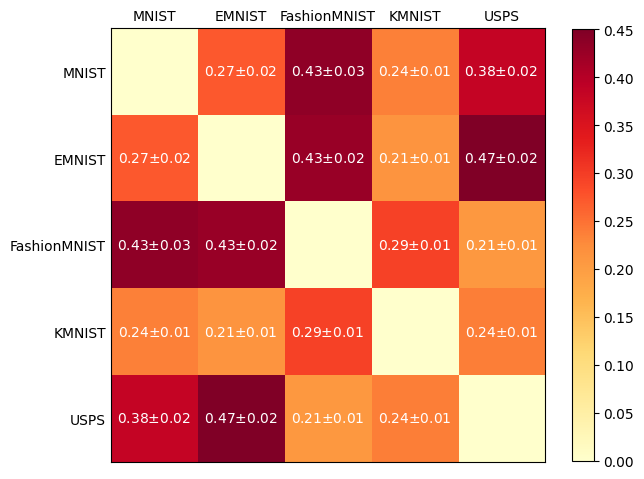

In [22]:
d_mean_sw = np.mean(d_sw, axis=0)
d_std_sw = np.std(d_sw, axis=0)

## SW + labels

fig, ax = plt.subplots(1,1,figsize=(7,7))
cb = ax.imshow(d_mean_sw, cmap="YlOrRd", vmax=0.45)#, cmap="Reds")

for (j,i),label in np.ndenumerate(d_mean_sw):
    if i!=j:
        ax.text(i, j, str(np.round(label, 2)) + r"$\pm$" + str(np.round(d_std_sw[i, j], 2)),
                ha='center', va='center', c="white")

ax.xaxis.tick_top()

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(names)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(names)

ax.tick_params(axis=u'both', which=u'both',length=0)

fig.colorbar(cb, ax=ax, shrink=0.8)
plt.savefig("./dist_matrix_sw.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [23]:
print(np.mean(ts), np.std(ts))

0.04816246032714844 0.003501070082975261


### Baseline OTDD

In [24]:
d_w = np.zeros((5,5))
ts_w = []

t = 0

for i in range(5):
    _, Yi = emb.preprocess_dataset(train_all[i])

    for j in range(i):
        _, Yj = emb.preprocess_dataset(train_all[j])
        
        idx_yi = i * emb.class_num + Yi.cpu().numpy()
        idx_yj = j * emb.class_num + Yj.cpu().numpy()
                
        d_labels_ij = torch.tensor(distance_array[np.ix_(idx_yi, idx_yj)], device=device)# **2
        
        a = torch.from_numpy(ot.unif(data_X[i].shape[0])).to(device)
        b = torch.from_numpy(ot.unif(data_X[j].shape[0])).to(device)
        
        t_init = time.time()
        M = ot.dist(data_X[i], data_X[j], metric="sqeuclidean") + d_labels_ij
        w = ot.emd2(a, b, M)
        t += time.time()-t_init
        
        d_w[i, j] = w.item()
        d_w[j, i] = w.item()
        
print(t)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

/share/home/bonet/.conda/envs/swspd/lib/python3.10/site-packages/ot/lp/__init__.py:557: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

154.81651282310486


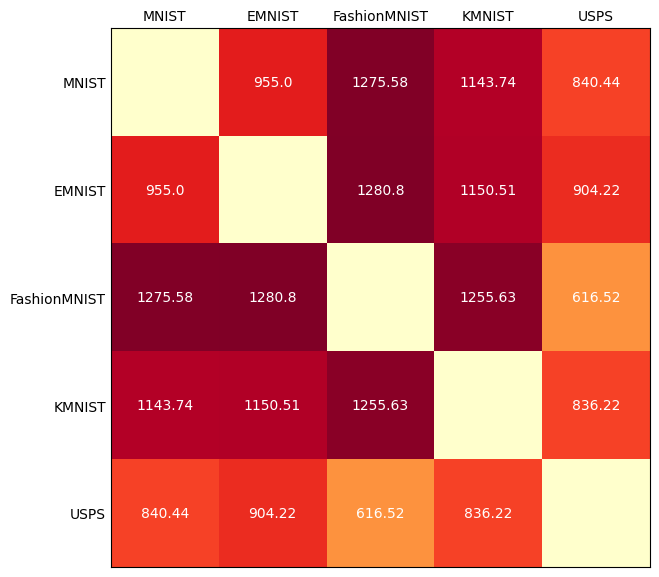

In [26]:
## W on OTDD

fig, ax = plt.subplots(1,1,figsize=(7,7))
# ax.imshow(d_w)
cb = ax.imshow(d_w, cmap="YlOrRd") #, vmax=0.45)#, cmap="Reds")

for (j,i),label in np.ndenumerate(d_w):
    if i != j:
        ax.text(i, j, np.round(label, 2) ,ha='center', va='center', c="white")
    
ax.xaxis.tick_top()

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(names)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(names)

ax.tick_params(axis=u'both', which=u'both',length=0)
    
plt.show()